#  Introduction

## Problem Statement
*  there is a change in trend that occurs due to uncertain conditions causing excessive stock of goods, so sometimes goods that have been purchased cannot be resold because the product has been piling up too long in the inventory.

*  determining the storage of stock goods by analyzing using sales data for the previous month / year because the data in the previous month usually has an impact on future sales, while sales that occur do not always follow the previous month's data 

## Data Provided
The Data that is used in this project are
*     **sale_items.csv** - Contains the details of historical daily sales of a customer
*     **sales.csv** - Contains the historical daily sales of a customer
*     **sma_categories.csv** - Contains info about category of products
*     **sma_companies.csv** - Contains information about the customer of company X
*     **sma_products.csv** - Contains list of products that is sold in the companies
We will have a sneak peak into the dataset below 

# Content:
1. Data Preprocessing
     - Read the dataset
     - Drop null value and several columns
     - Merge all data
2. Exploratory Data Analysis
3. Search correlation between data
4. Implement model
     - use only data sales 
     - use with data external such as IHK, Inflasi, IHP
5. Use specific data for trend product
6. Use Time lag in analysis

In [1]:
#load library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os #using operating system dependent functionality
from datetime import datetime#datetime module supplies classes for manipulating dates and times.
import math # provides access to the mathematical functions
from IPython.display import display, HTML

#For Plotting
# Using plotly + cufflinks in offline mode
import plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

#For time series decomposition
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import timedelta

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

# 1. Data Preprocessing

## 1.1 Read Dataset

In [2]:
#read dataset
df_sales = pd.read_csv('proyek_skripsi/sales.csv')
df_sale_items = pd.read_csv('proyek_skripsi/sale_items.csv')
df_products = pd.read_csv('proyek_skripsi/sma_products.csv')
df_category = pd.read_csv('proyek_skripsi/sma_categories.csv')
df_companies = pd.read_csv('proyek_skripsi/sma_companies.csv')
df_ihk_inflasi = pd.read_csv("proyek_skripsi/Data_IHK_Inflasi_Nasional.csv")
df_ihp = pd.read_csv("proyek_skripsi/DataIHPKhususPlastikKaret.csv")

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.



## 1.2 Clean Dataset

In [3]:
def clean_data(dropped_column, df, negative_column = []):
    df = df.drop(dropped_column, axis=1)
    df = df[(df[negative_column] >= 0).all(1)]
    #df = df.fillna(0)
    df = df.dropna()
    return df

In [4]:
dropped_sales = ['note', 'staff_note', 'order_discount_id', 'updated_by', 'updated_at', 'return_id', 
                 'attachment', 'return_sale_ref', 'sale_id', 'rounding', 'suspend_note', 'address_id', 
                 'reserve_id', 'salesman_id', 'salesman_commission', 'total_commission', 'product_discount', 
                 'total_discount', 'grand_total', 'payment_term', 'due_date', 'paid', 'customer', 'quote_id', 
                 'reference_no', 'biller_id', 'biller', 'warehouse_id', 'order_discount', 'product_tax', 
                 'order_tax_id', 'order_tax', 'total_tax', 'shipping', 'pos', 'surcharge', 'api', 'shop', 'hash', 
                 'created_by', 'sale_status', 'payment_status', 'return_sale_total', 'total_items']

df_sales = clean_data(dropped_sales, df_sales, ['total'])
df_sales = df_sales.rename(columns={'id': 'sale_id'})
df_sales = df_sales.loc[(df_sales['date'] >= '2017-02-31')]
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17392 entries, 0 to 17496
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sale_id      17392 non-null  int64  
 1   date         17392 non-null  object 
 2   customer_id  17392 non-null  int64  
 3   total        17392 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 679.4+ KB


In [5]:
dropped_saleitems = ['serial_no', 'sale_item_id', 'comment', 'id', 'product_type', 'option_id', 'unit_price', 
                     'net_unit_price', 'warehouse_id', 'item_tax', 'tax_rate_id', 'tax', 'product_unit_id', 
                     'product_unit_code', 'unit_quantity']

df_sale_items = clean_data(dropped_saleitems, df_sale_items, ['quantity', 'item_discount', 'real_unit_price', 'subtotal'])
df_sale_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52393 entries, 5 to 52594
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sale_id          52393 non-null  int64  
 1   product_id       52393 non-null  int64  
 2   product_code     52393 non-null  object 
 3   product_name     52393 non-null  object 
 4   quantity         52393 non-null  float64
 5   discount         52393 non-null  object 
 6   item_discount    52393 non-null  float64
 7   subtotal         52393 non-null  float64
 8   real_unit_price  52393 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 4.0+ MB


In [6]:
dropped_product = ['code', 'name', 'unit', 'product_price', 'alert_quantity', 'image', 'subcategory_id', 'cf1', 'cf2', 'cf3', 'cf4',
       'cf5', 'cf6', 'quantity', 'tax_rate', 'track_quantity', 'details',
       'warehouse', 'barcode_symbology', 'file', 'product_details',
       'tax_method', 'type', 'supplier1', 'supplier1price', 'supplier2',
       'supplier2price', 'supplier3', 'supplier3price', 'supplier4',
       'supplier4price', 'supplier5', 'supplier5price', 'promotion',
       'promo_price', 'start_date', 'end_date', 'supplier1_part_no',
       'supplier2_part_no', 'supplier3_part_no', 'supplier4_part_no',
       'supplier5_part_no', 'sale_unit', 'purchase_unit', 'brand', 'slug',
       'featured', 'weight']

df_products = clean_data(dropped_product, df_products)
df_products = df_products.rename(columns={'id': 'product_id'})
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5746 entries, 0 to 5745
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product_id   5746 non-null   int64  
 1   cost         5746 non-null   float64
 2   category_id  5746 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 179.6 KB


In [7]:
dropped_category = ['image', 'parent_id', 'slug']

df_category = clean_data(dropped_category, df_category)
df_category = df_category.rename(columns={'id': 'category_id', 'code': 'category_code', 'name': 'category_name'})
#df_category = df_category['category_name'].to_string(na_rep='').lower()
df_category = df_category.applymap(lambda s:s.lower() if type(s) == str else s)
df_category.category_name = [c.replace(' ', '_') for c in df_category.category_name]
df_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    40 non-null     int64 
 1   category_code  40 non-null     object
 2   category_name  40 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.2+ KB


In [8]:
dropped_companies = ['group_id', 'vat_no', 'group_name', 'customer_group_id',
       'customer_group_name', 'name', 'address', 'state', 'postal_code', 'country', 'phone', 'email', 'cf1', 'cf2',
       'cf3', 'cf4', 'cf5', 'cf6', 'invoice_footer', 'payment_term', 'logo',
       'award_points', 'deposit_amount', 'price_group_id', 'price_group_name',
       'email_footer']

df_companies = clean_data(dropped_companies, df_companies)
df_companies = df_companies.rename(columns={'id': 'customer_id'})
df_companies = df_companies[~df_companies.city.str.contains("-")]
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 454
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  441 non-null    int64 
 1   company      441 non-null    object
 2   city         441 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.8+ KB


### make variant of location into one location

In [9]:
#change list into Jawa
list_jawa = ['JAWA TIMUR', 'BALI', 'SURABAYA', 'MADURA', 'JAWA TENGAH', 'JAKARTA', 'DENPASAR', 'JAWA TINUR', 'SBY', 'PARE-KEDIRI, JATIM', 'BAU BAU', 'BONDOWOSO', 
    'GRESIK', 'TULUNGAGUNG, JAWA TIMUR', 'LOMBOK', 'JAWA TENGGAH', 'BLITAR, JAWA TIMUR',
    'JOGJA', '( PERUM DARMO SENTOSA RAYA) ,SURABAYA', 'JAKARTA BARAT', 'BLORA, JAWA TENGAH'
    'PASURUAN, JAWA TIMUR', 'BOJONEGORO', 'JAWA BARAT', 'GENTENG', 'CEPU', 'KEDIRI, JAWA TIMUR', 'SURABAYA, JATIM', 'MALANG']

for i in list_jawa:
    df_companies.loc[df_companies['city'].str.contains(i), 'city'] = 'JAWA'

    
#change list into sulawesi
list_sulawesi = ["BANGGAI, SULAWESI", "SLAWESI", "WAKATOBI, SULAWESI", "MAKASAR"]

for i in list_sulawesi:
    df_companies.loc[df_companies['city'].str.contains(i), 'city'] = 'SULAWESI'

    
#change list into papua
list_papua = ["JAYAPURA", "MERAUKE"]

for i in list_papua:
    df_companies.loc[df_companies['city'].str.contains(i), 'city'] = 'PAPUA'


#change list into kalimantan
df_companies.loc[df_companies['city'].str.contains(" KALIMANTAN"), 'city'] = 'KALIMANTAN'


#change list into nusa tenggara
list_nusatenggara = ["NTT", "NTB"]

for i in list_nusatenggara:
    df_companies.loc[df_companies['city'].str.contains(i), 'city'] = 'NUSA TENGGARA'


df_companies['city'].value_counts()

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



JAWA             201
SULAWESI         126
KALIMANTAN        67
PAPUA             33
NUSA TENGGARA     13
SUMATRA            1
Name: city, dtype: int64

## 1.3 merge all data

In [10]:
df_sales_saleitems = pd.merge(df_sales, df_sale_items, on='sale_id', how='inner')
df_sales_items_product = pd.merge(df_sales_saleitems, df_products, on='product_id', how='outer')
df_sales_prod_category = pd.merge(df_sales_items_product, df_category, on='category_id', how='outer')
df_result = pd.merge(df_sales_prod_category, df_companies, on='customer_id', how='outer')

In [11]:
df_result = df_result.dropna()
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51598 entries, 0 to 52780
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sale_id          51598 non-null  float64
 1   date             51598 non-null  object 
 2   customer_id      51598 non-null  float64
 3   total            51598 non-null  float64
 4   product_id       51598 non-null  float64
 5   product_code     51598 non-null  object 
 6   product_name     51598 non-null  object 
 7   quantity         51598 non-null  float64
 8   discount         51598 non-null  object 
 9   item_discount    51598 non-null  float64
 10  subtotal         51598 non-null  float64
 11  real_unit_price  51598 non-null  float64
 12  cost             51598 non-null  float64
 13  category_id      51598 non-null  float64
 14  category_code    51598 non-null  object 
 15  category_name    51598 non-null  object 
 16  company          51598 non-null  object 
 17  city        

In [12]:
df_result.head()

,sale_id,date,customer_id,total,product_id,product_code,product_name,quantity,discount,item_discount,subtotal,real_unit_price,cost,category_id,category_code,category_name,company,city
0,22.00,2017-07-15 13:35:00,127.00,2000000.00,438.00,ABE-003,ESKAN MINI KARINA,40.00,0,0.00,2000000.00,50000.00,49200.00,2.00,eskan,eskan,DAMAI SANTOSO,JAWA
1,421.00,2017-08-30 15:27:38,127.00,7364400.00,438.00,ABE-003,ESKAN MINI KARINA,40.00,0,0.00,2000000.00,50000.00,49200.00,2.00,eskan,eskan,DAMAI SANTOSO,JAWA
2,639.00,2017-10-03 11:34:54,127.00,1600000.00,438.00,ABE-003,ESKAN MINI KARINA,32.00,0,0.00,1600000.00,50000.00,49200.00,2.00,eskan,eskan,DAMAI SANTOSO,JAWA
3,921.00,2017-11-14 14:27:00,127.00,2000000.00,438.00,ABE-003,ESKAN MINI KARINA,40.00,0,0.00,2000000.00,50000.00,49200.00,2.00,eskan,eskan,DAMAI SANTOSO,JAWA
4,1043.00,2017-11-28 14:38:00,127.00,2680000.00,438.00,ABE-003,ESKAN MINI KARINA,8.00,0,0.00,400000.00,50000.00,49200.00,2.00,eskan,eskan,DAMAI SANTOSO,JAWA


# 2. Exploratory Data Analysis

- total quantity each province
- total quantity each product categories
- trend and seasonal for dataset
- trend and seasonal for data external

## 2.1 Total Quantity for each province

In [13]:
#quantity of province
print(df_result.city.value_counts())
df_result.city.value_counts(normalize =True) 

JAWA             20471
SULAWESI         14992
KALIMANTAN       10601
PAPUA             5191
NUSA TENGGARA      341
SUMATRA              2
Name: city, dtype: int64


JAWA            0.40
SULAWESI        0.29
KALIMANTAN      0.21
PAPUA           0.10
NUSA TENGGARA   0.01
SUMATRA         0.00
Name: city, dtype: float64

In [14]:
city_data = df_result.groupby('city').agg({"quantity":"sum"})
city_data.sort_values(by='quantity', ascending=False)

,quantity
city,
SULAWESI,1199185.00
JAWA,829046.00
KALIMANTAN,792498.50
PAPUA,270544.50
NUSA TENGGARA,13157.00
SUMATRA,88.00


In [15]:
#function for plotting
def bar_plot(xlabel, ylabel, title, x1, y1, rotate):
    plt.bar(x1, y1, width = 0.4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.title(title,fontweight = "bold")
    plt.ticklabel_format(style='plain', axis='y')
    plt.gcf().autofmt_xdate(rotation=rotate)
    plt.show()

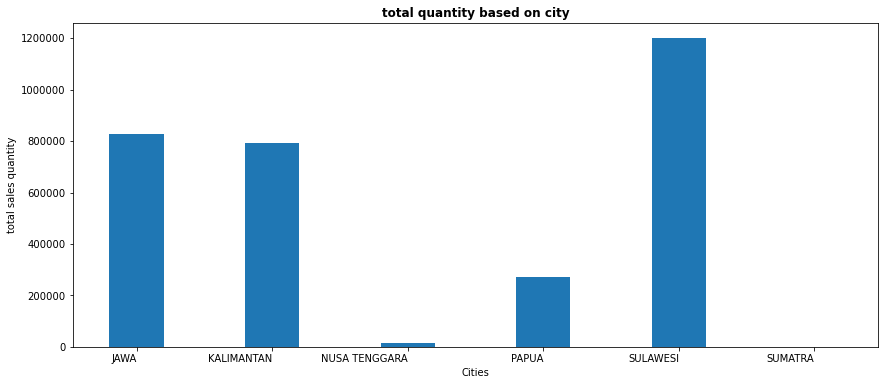

In [16]:
#plot the barchart
bar_plot("Cities", "total sales quantity", "total quantity based on city", city_data.index, city_data['quantity'], 0)

## 2.2 Total Quantity for each product categories

In [17]:
#Let's have a look at the total sales from each of the 3 categries
print("Total Quantity from each category")
category_data = df_result.groupby('category_name').agg({"quantity":"sum"})
category_data.sort_values(by='quantity', ascending=False).head(10)

Total Quantity from each category


,quantity
category_name,
general,783497.50
sealware/toples,397111.50
peralatan makan,371442.50
peralatan dapur,252912.00
pot,199912.50
hanger,167665.00
tempat_penyimpanan_mkn,156635.00
bak/ember,133825.00
botol_air,93446.00


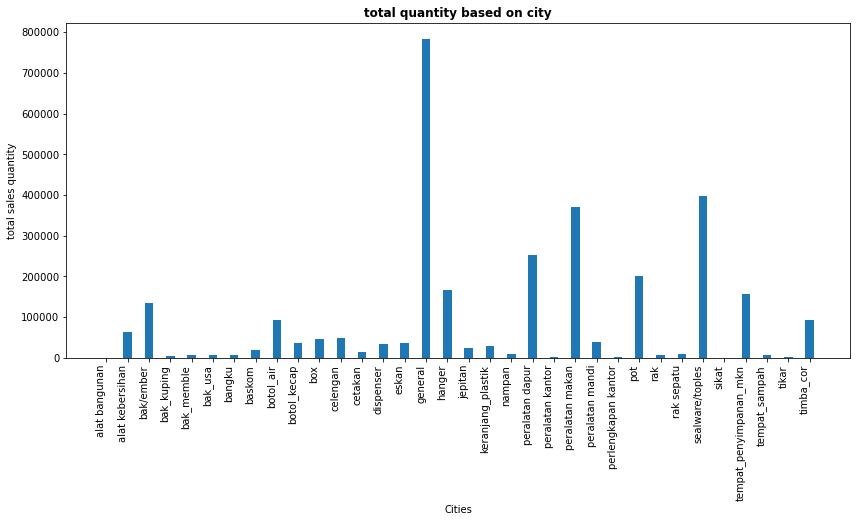

In [18]:
#plot the barchart
bar_plot("Cities", "total sales quantity", "total quantity based on city", category_data.index, category_data['quantity'], 90)

## 2.3 Plot Total Quantity for Product Categories with Date (top 8)

In [19]:
#sum of quantity, total and real unit price monthly grouped by category
#####################################################
df_result['date'] = pd.to_datetime(df_result['date'], errors='coerce')
monthly_sales=df_result.groupby([df_result.date.dt.to_period("M"),"category_code"])[
    "quantity", "total", "real_unit_price"].agg({"real_unit_price":"mean","quantity":"sum","total":"mean"})
monthly_sales.reset_index(level=[1], inplace=True)

<ipython-input-19-18b6288317b7>:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [20]:
monthly_sales.interpolate(inplace = True)
monthly_sales.index=monthly_sales.index.get_level_values('date').to_timestamp()
monthly_sales.drop(['total', 'real_unit_price'], axis=1, inplace=True)

In [21]:
monthly_sales.head()

,category_code,quantity
date,,
2017-07-01,bak/ember,1902.00
2017-07-01,bakusa,21.00
2017-07-01,bangku,258.50
2017-07-01,box,331.50
2017-07-01,bskm,75.00


In [22]:
monthly_sales['category_code'].value_counts()

eskan              50
tempat sampah      50
disp               50
keb                50
pot                50
bak/ember          50
nampan             50
tpm                50
sealware/toples    50
mnd                50
btlair             50
cl                 50
general            50
hngr               50
dpr                50
krj                50
mkn                50
cetakan            49
box                49
bangku             48
bkcp               48
rak                48
bak                47
rksp               47
bskm               46
jepitan            45
bakusa             43
knt                37
tc                 36
bakkp              35
kant               32
sikat               7
tkr                 1
bng                 1
tik                 1
Name: category_code, dtype: int64

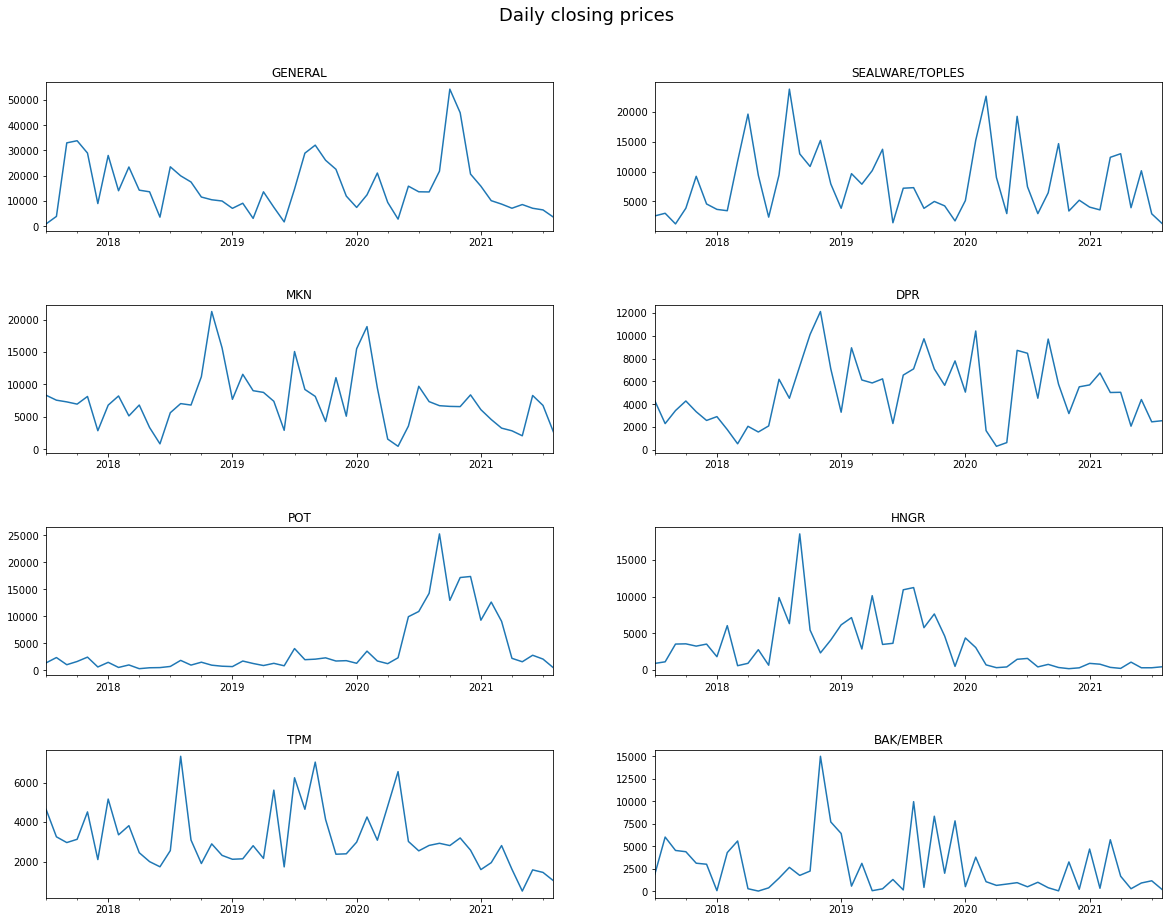

In [23]:
# define subplot grid
top_category = ['general', 'sealware/toples', 'mkn', 'dpr', 'pot', 'hngr', 'tpm', 'bak/ember']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(top_category, axs.ravel()):
    # filter df for ticker and plot on specified axes
    monthly_sales[monthly_sales["category_code"] == ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.ticklabel_format(style='plain', axis='y')

plt.show()

### See Decomposition of Dataset to see seasonality and trend

In [24]:
category_month_sales = monthly_sales.pivot(columns='category_code', values='quantity')
category_month_sales.head()

category_code,bak,bak/ember,bakkp,bakusa,bangku,bkcp,bng,box,bskm,btlair,...,pot,rak,rksp,sealware/toples,sikat,tc,tempat sampah,tik,tkr,tpm
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,nan,1902.00,nan,21.00,258.50,nan,nan,331.50,75.00,2626.00,...,1398.50,36.00,535.00,2584.00,nan,nan,159.00,nan,nan,4644.00
2017-08-01,9.00,6036.00,nan,345.00,526.50,489.00,nan,406.00,111.00,1691.00,...,2382.50,136.00,298.00,3027.00,nan,1500.00,304.50,nan,nan,3252.00
2017-09-01,nan,4550.00,nan,402.00,226.00,757.00,nan,231.50,346.00,1231.00,...,1058.50,86.00,204.00,1245.00,nan,nan,101.00,nan,nan,2961.00
2017-10-01,87.00,4409.00,nan,45.00,91.00,759.00,nan,141.50,1643.00,1224.00,...,1654.00,54.00,432.00,3875.00,nan,nan,251.00,nan,nan,3126.00
2017-11-01,9.00,3133.00,nan,3.00,141.00,1031.00,nan,26.50,193.00,909.00,...,2457.00,54.00,224.00,9218.00,nan,1450.00,71.00,nan,nan,4514.00


In [25]:
top8_month_sales = pd.concat([category_month_sales['general'], category_month_sales['sealware/toples'], category_month_sales['mkn'], category_month_sales['dpr'], category_month_sales['pot'], category_month_sales['hngr'], category_month_sales['tpm'], category_month_sales['btlair'], category_month_sales['bak/ember']], axis=1)
top8_month_sales.head()

,general,sealware/toples,mkn,dpr,pot,hngr,tpm,btlair,bak/ember
date,,,,,,,,,
2017-07-01,922.00,2584.00,8329.00,4297.00,1398.50,898.00,4644.00,2626.00,1902.00
2017-08-01,3895.50,3027.00,7565.50,2287.00,2382.50,1114.00,3252.00,1691.00,6036.00
2017-09-01,32992.50,1245.00,7301.50,3433.00,1058.50,3535.00,2961.00,1231.00,4550.00
2017-10-01,33837.00,3875.00,6957.00,4274.00,1654.00,3565.00,3126.00,1224.00,4409.00
2017-11-01,28958.00,9218.00,8140.00,3329.00,2457.00,3254.00,4514.00,909.00,3133.00
2017-12-01,8973.00,4585.00,2848.00,2564.00,640.50,3532.00,2099.00,852.00,3019.00
2018-01-01,28009.00,3678.00,6800.00,2900.00,1497.00,1809.00,5165.00,840.00,84.00
2018-02-01,14046.50,3455.00,8216.50,1763.00,554.00,6047.00,3353.00,1036.00,4312.00
2018-03-01,23443.00,11745.00,5139.00,513.00,1015.00,586.00,3817.00,855.00,5599.00


In [26]:
# monthly_decomposition = seasonal_decompose(monthly_sales.quantity, model='multiplicable')
# monthly_decomposition.plot()
# pyplot.show()

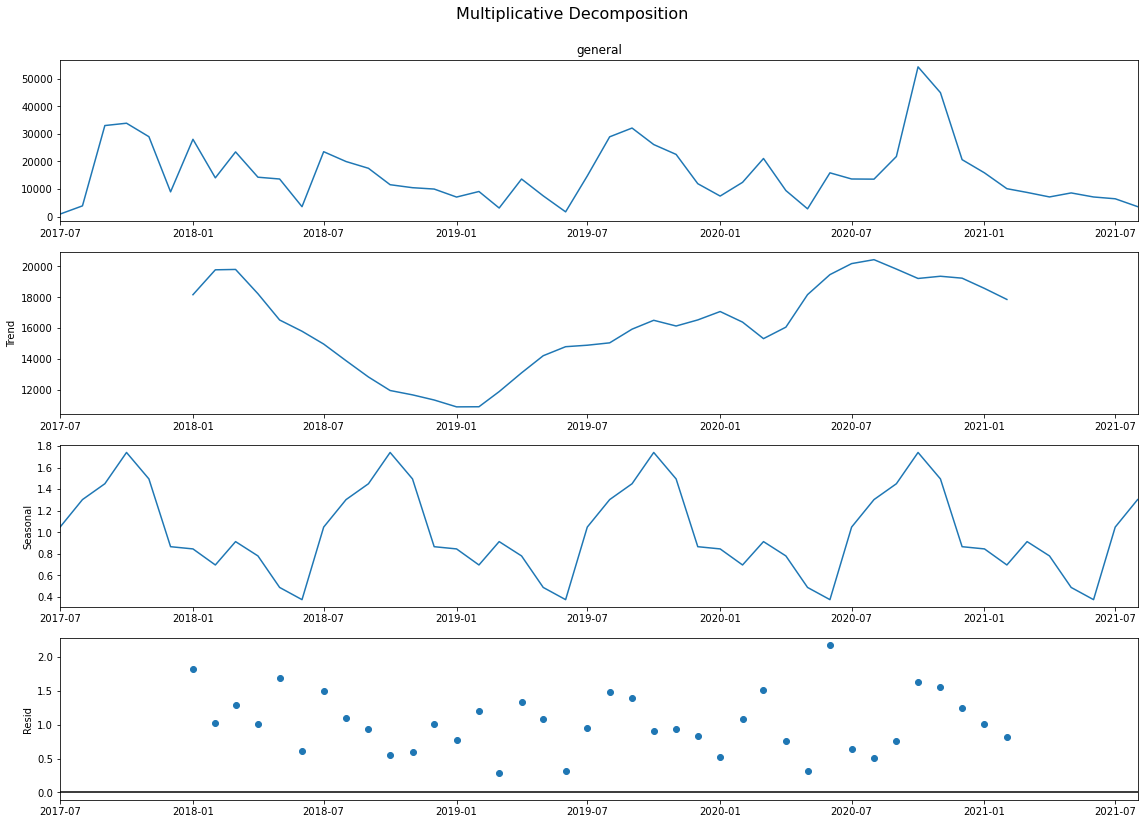

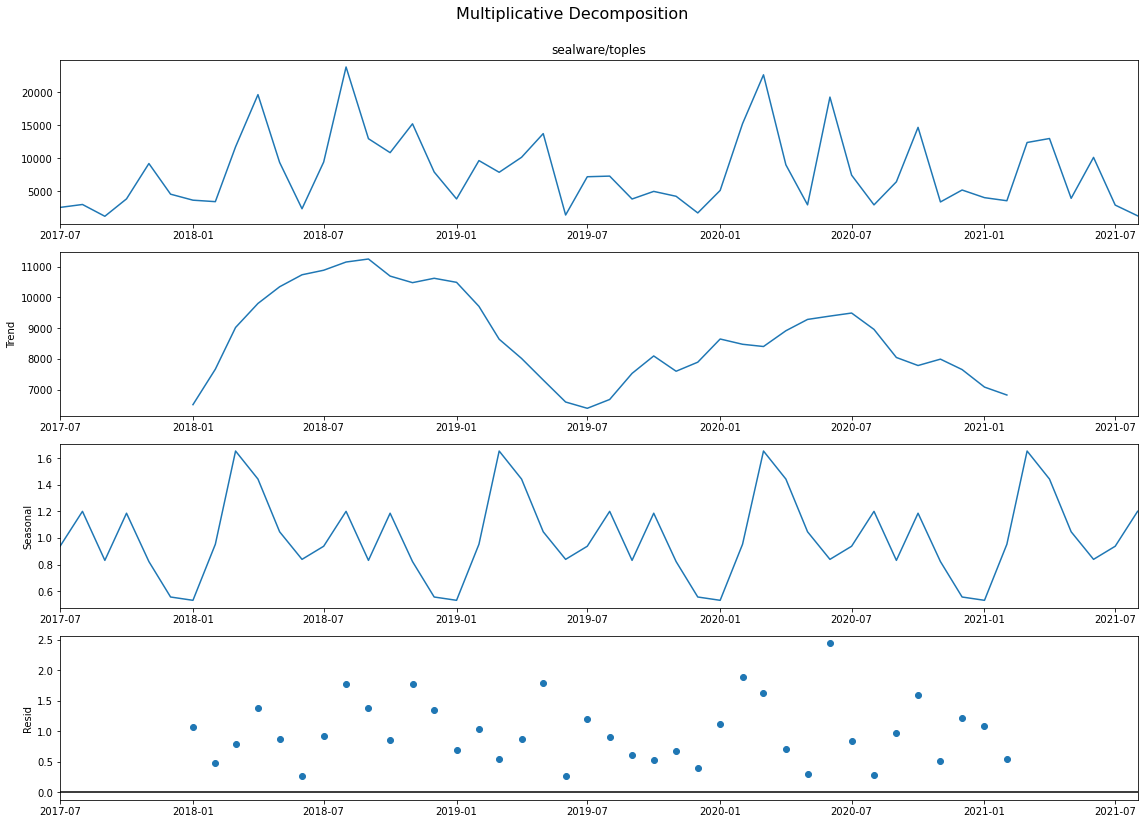

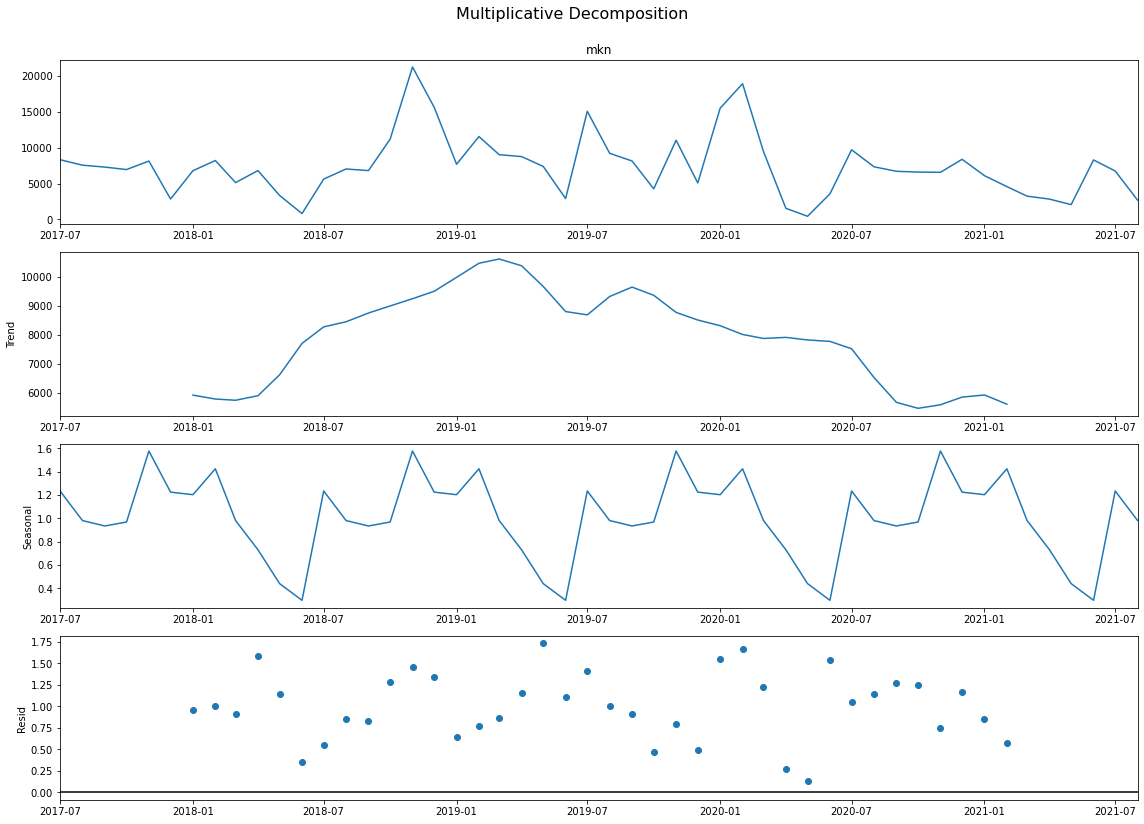

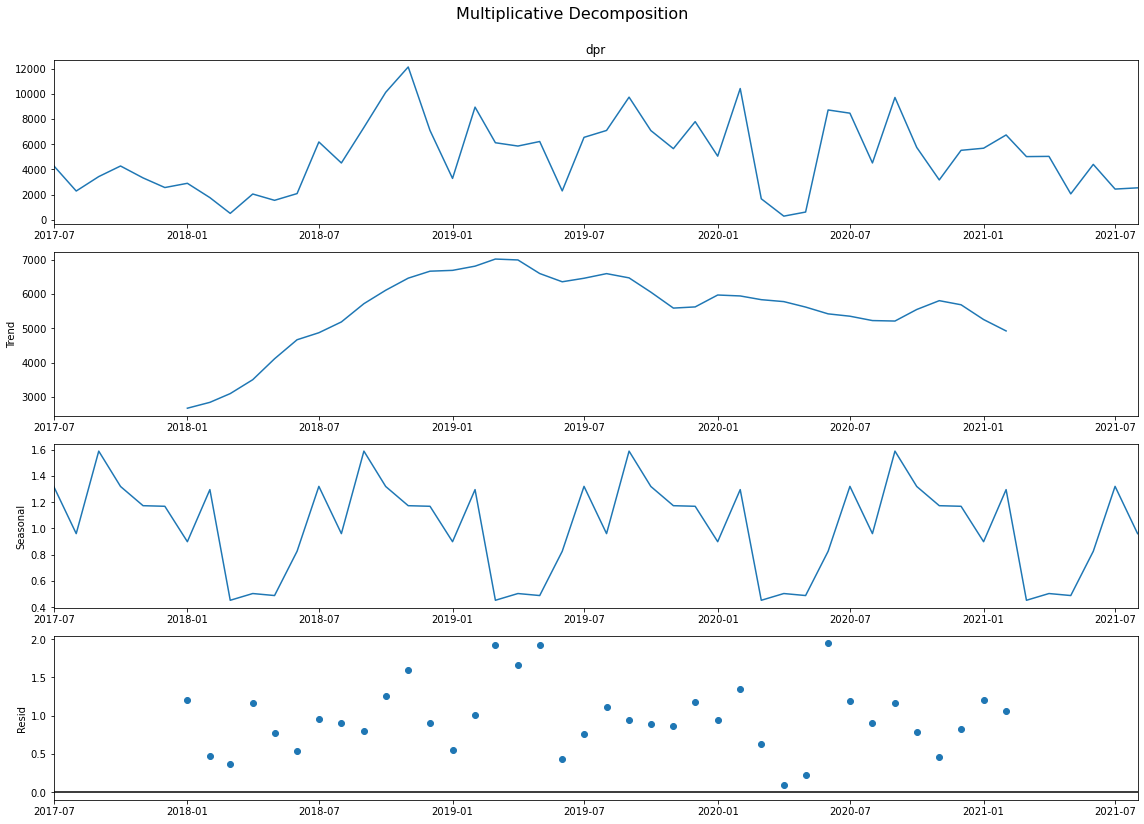

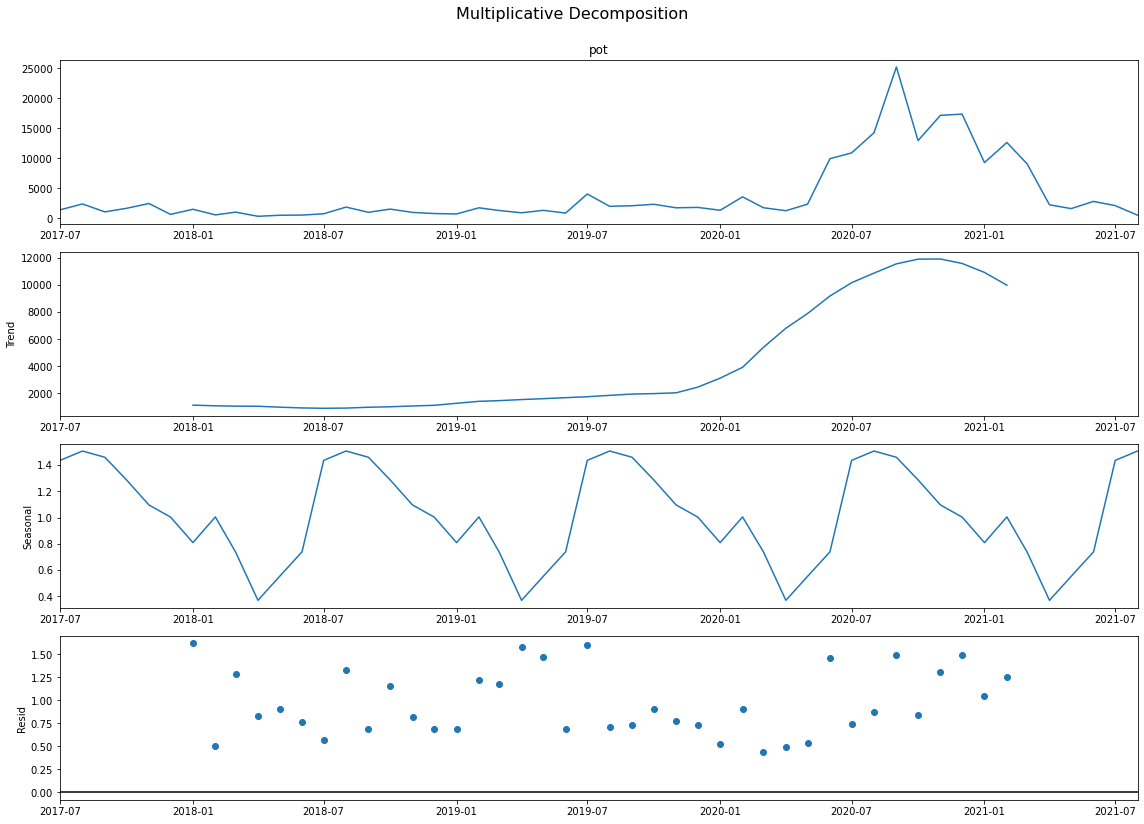

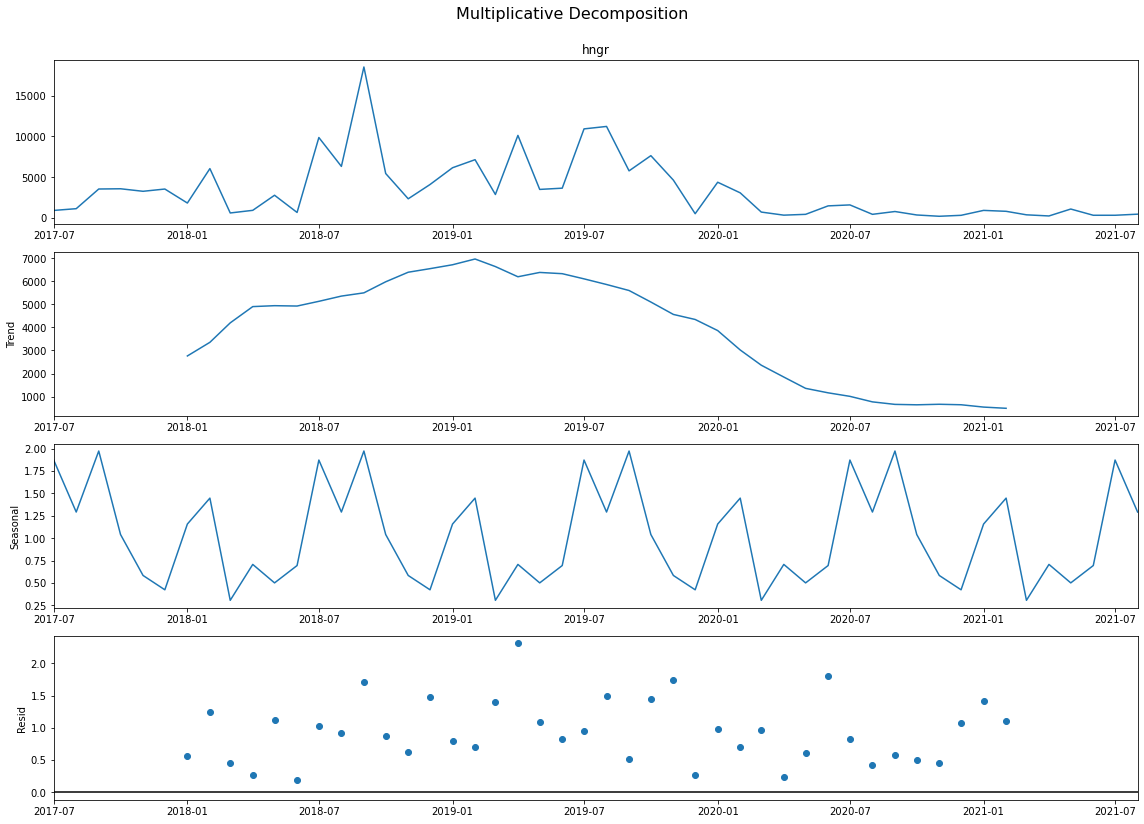

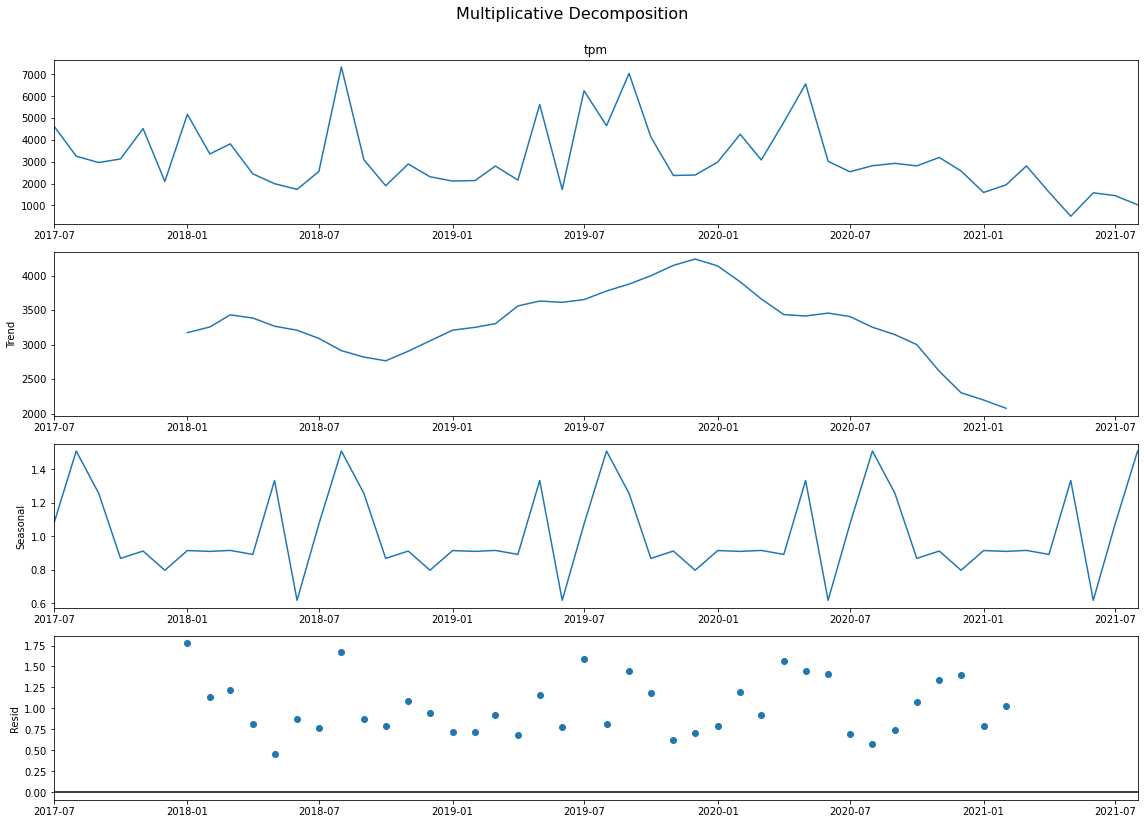

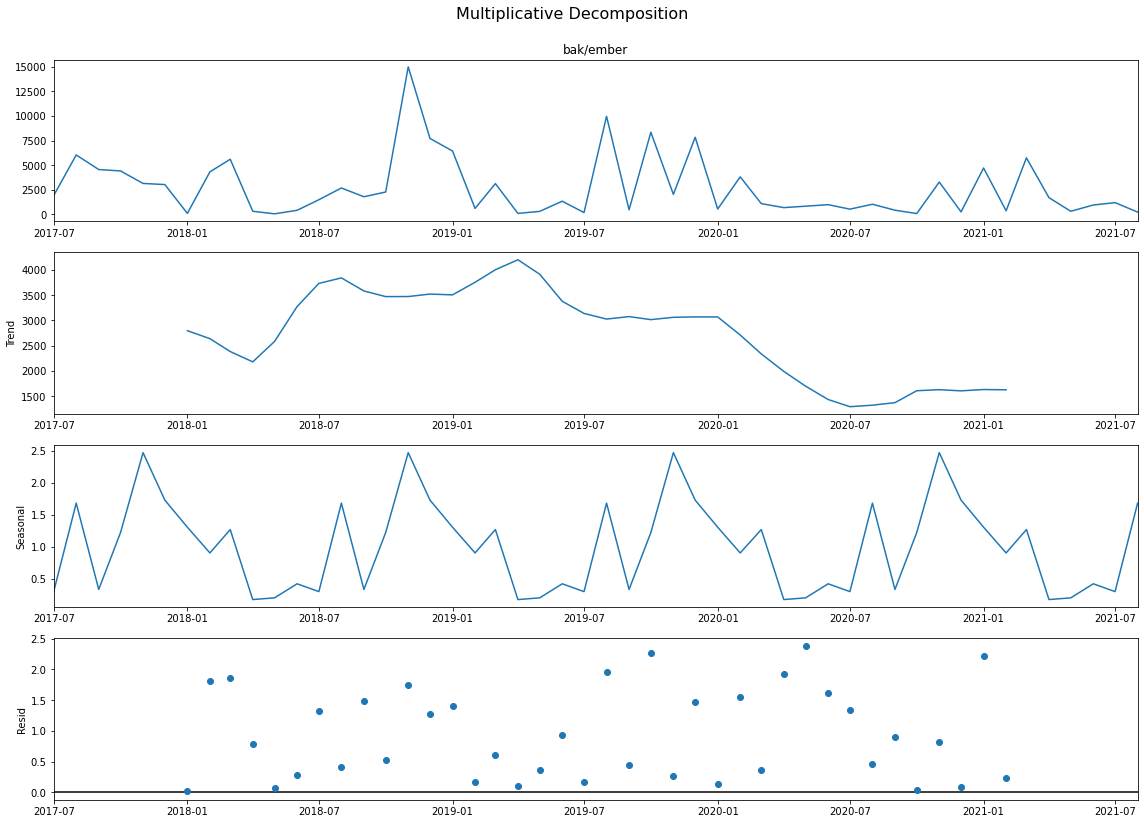

In [34]:
from dateutil.parser import parse

# loop through tickers and axes
for ticker in top_category:
    # filter df for ticker and plot on specified axes
    multiplicative_decomposition = seasonal_decompose(top8_month_sales[ticker], model='multiplicative')
    
    plt.rcParams.update({'figure.figsize': (16,12)})
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

### Insight yang didapat
- General : setiap akhir tahun (bulan november dan desember mengalami penurunan penjualan), di bulan juni kebanyakan mengalami penurunan penjualan kecuali bulan 2020 juni

- Toples : awal tahun seperti bulan maret sering mengalami kenaikan penjualan kecuali 2019 maret

- Makan : mulai terjadi penurunan penjualan bulan maret, peak di bulan juni untuk 2018, 2019 dan di 2020, 2021 di mei

- Dapur : 

- Pot : terjadi penurunan penjualan pada bulan april, mulai booming / laris saat tahun 2020 juni 

- Hngr : terjadi penuruan  penjualan pada bulan maret, penjualan menurun drastis setelah tahun 2020 

- tempat makan :   

- bak/ember : terjadi penuruan  penjualan pada bulan april

# 3. Implement Model

## 3.1 Implement GRU

In [31]:
#General Trend and Seasonal Sales
# top6_month_sales = monthly_sales.loc[pd.IndexSlice[:, ['general', 'sealware/toples', 'peralatan makan', 'peralatan dapur', 'pot', 'hanger']], :]
# print(type(monthly_sales.index.get_level_values('date')))

In [32]:
#top6_month_sales = pd.to_datetime(top6_month_sales.index.get_level_values('date'), errors='coerce')
# top6_month_sales.index.get_level_values("date").dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')

# print(type(top6_month_sales.index.get_level_values('date')))

In [33]:
#sum of quantity, total and real unit price monthly
#####################################################
# df_result['date'] = pd.to_datetime(df_result['date'], errors='coerce')
# #Monthly sales
# df_sales_month = df_result[["date", "quantity", "total", "real_unit_price", "category_name"]]
# monthly = df_sales_month.date.dt.to_period("M")
# sales_monthly = df_sales_month.groupby(monthly).sum()